In [1]:
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# !conda env list

In [4]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import pandas as pd
import numpy as np

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [5]:
mnist_train = datasets.FashionMNIST('./fashion_mnist/train', download=True, train=True,
                                    transform=transforms.Compose([transforms.ToTensor()]))
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashion_mnist/train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
mnist_test = datasets.FashionMNIST('./fashion_mnist/test', download=True, train=False,
                                    transform=transforms.Compose([transforms.ToTensor()]))

In [7]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [12]:
def calc_metric_test(model, test_loader, loss_fn):
    accuracy = 0
    loss_test = 0
    n = 0
    
    with torch.no_grad():
        for j, (X, y) in enumerate(test_loader):
            y_pred = model(X)
            accuracy += torch.sum(torch.eq(y_pred.argmax(dim=1).long(), y))
            n += y_pred.shape[0]
            loss_test += loss_fn(y_pred, y)
            
    return accuracy / n, loss_test / j    

In [13]:
def train_model(model, train_df, test_df, epoch):
    optimizer = torch.optim.Adam(params=model.parameters())
    loss = torch.nn.CrossEntropyLoss()
    
    train_loader = DataLoader(train_df, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_df, batch_size=512, shuffle=True)
    
    accuracy = []
    train_loss = []
    test_loss = []
    
    for i in range(epoch + 1):
        running_loss = 0.0
        model.train()
        
        for j, (X, y) in enumerate(train_loader, 1):
            
            X = X.data
            y = y.data
            optimizer.zero_grad()
            output = model(X)
            loss_fn = loss(output, y)
            loss_fn.backward()
            optimizer.step() 
                
            running_loss += loss_fn.item()
            
        model.eval()
        test_accuracy, loss_test = calc_metric_test(model, test_loader, loss)
        
        accuracy.append(test_accuracy)
        test_loss.append(loss_test.item())
        train_loss.append(running_loss / j)
        print('Epoch', i + 1)
        print('Train loss', running_loss / j)
        print('Test loss', loss_test.item())
        print('-' * 20)
        
    return model, train_loss, test_loss, accuracy

In [14]:
# for j, (x, y) in enumerate(trainloader, 1):
#     print(j)
#     print(x.data)
#     print(y.data)
#     break

In [15]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 2048),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(32, len(mnist_train.classes))
)

In [16]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, mnist_train, mnist_test, 20)

Epoch 1
Train loss 0.8093444882616051
Test loss 0.46615105867385864
--------------------
Epoch 2
Train loss 0.5413526725540283
Test loss 0.4279678165912628
--------------------
Epoch 3
Train loss 0.4637043321850712
Test loss 0.4014085829257965
--------------------
Epoch 4
Train loss 0.4176979906745811
Test loss 0.3764997124671936
--------------------
Epoch 5
Train loss 0.394011684635809
Test loss 0.37813979387283325
--------------------
Epoch 6
Train loss 0.3765456633749547
Test loss 0.36438804864883423
--------------------
Epoch 7
Train loss 0.36423292833922516
Test loss 0.3788732588291168
--------------------
Epoch 8
Train loss 0.3503375038552259
Test loss 0.3556031286716461
--------------------
Epoch 9
Train loss 0.34271330295849456
Test loss 0.3581303656101227
--------------------
Epoch 10
Train loss 0.32870378303947223
Test loss 0.35640063881874084
--------------------
Epoch 11
Train loss 0.3205991503335774
Test loss 0.3437369465827942
--------------------
Epoch 12
Train loss 0.30

In [17]:
params = []
for param in model.parameters():
    params.append(torch.prod(torch.tensor(param.shape)))

sum(params)

tensor(1673578)

In [18]:
accuracy = [i.item() for i in accuracy]

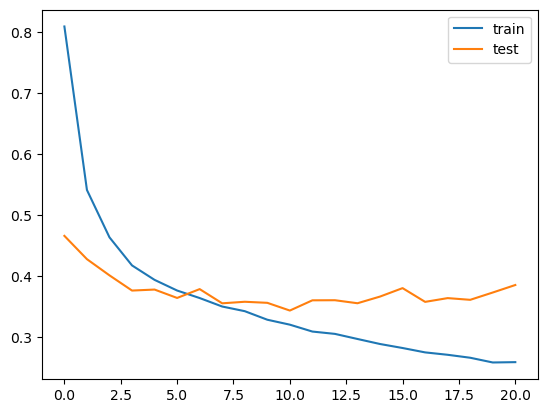

In [21]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend();

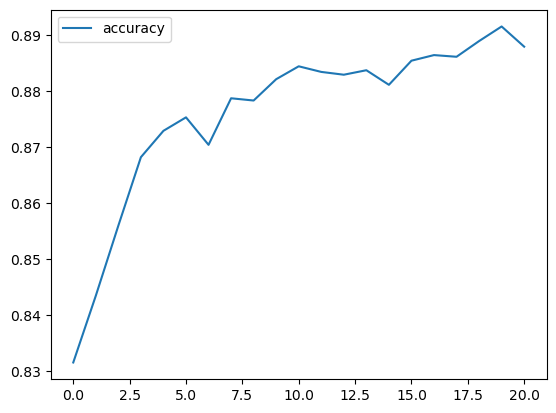

In [22]:
plt.plot(accuracy, label='accuracy')
plt.legend()

In [23]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=2048, bias=True)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['1.weight', '1.bias', '3.weight', '3.bias', '6.weight', '6.bias'])


In [25]:
torch.save(model.state_dict(), 'mnist_fashion_using_linear_nn')

In [44]:
from sklearn.metrics import confusion_matrix

y_pred = torch.zeros(mnist_test.data.shape[0])
with torch.no_grad():
    i = 0
    for images, labels in DataLoader(mnist_test, batch_size=64):
        images = images.view(images.shape[0], -1)
        proba = model(images)
    
        y_pred[i:i + 64] += proba.argmax(1)
        i += 64

cf_matrix = confusion_matrix(mnist_test.targets.numpy(), y_pred.long().numpy())

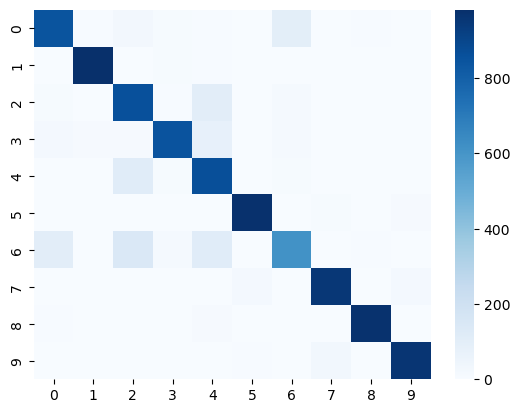

In [52]:
sns.heatmap(cf_matrix, cmap='Blues');

In [56]:
mnist_test.classes[0]

'T-shirt/top'

In [68]:
id_pred = model(mnist_test.data[0:1].float()).argmax(dim=1).item()

True label - T-shirt/top
Predict label - Ankle boot


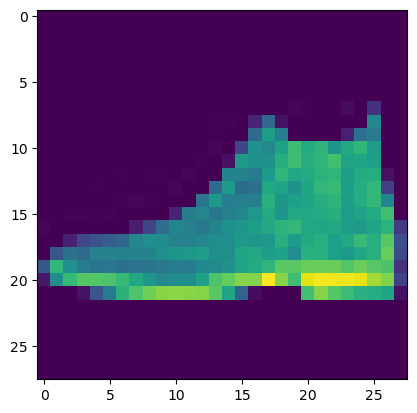

In [88]:
print(f'True label - {mnist_test.classes[0]}\n'
      f'Predict label - {mnist_test.classes[id_pred]}')
plt.imshow((mnist_test.data[0]));

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [89]:
mnist_train = datasets.FashionMNIST('./fashion_mnist/train', train=True,
                                    transform=transforms.Compose([transforms.ToTensor()]))
mnist_test = datasets.FashionMNIST('./fashion_mnist/test', train=False,
                                   transform=transforms.Compose([transforms.ToTensor()]))

In [90]:
model = torch.nn.Sequential(
    
    torch.nn.BatchNorm2d(1),

    torch.nn.Conv2d(1, 8, (3, 3), padding=1),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),

    torch.nn.Conv2d(8, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),

    torch.nn.Dropout(0.5),

    torch.nn.Flatten(),
    torch.nn.Linear(12544, 2048),
    torch.nn.Sigmoid(),
    torch.nn.Linear(2048, 10)
)

In [91]:
params = []
for param in model.parameters():
    params.append(torch.prod(torch.tensor(param.shape)))

sum(params)

tensor(25717548)

In [95]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, mnist_train, mnist_test, 10)

Epoch 1
Train loss 0.23751095442448633
Test loss 0.2535945773124695
--------------------
Epoch 2
Train loss 0.19037480513423177
Test loss 0.24355895817279816
--------------------
Epoch 3
Train loss 0.1555902945288157
Test loss 0.23594892024993896
--------------------
Epoch 4
Train loss 0.13013782238556168
Test loss 0.2216806411743164
--------------------
Epoch 5
Train loss 0.1087844380003921
Test loss 0.21100275218486786
--------------------
Epoch 6
Train loss 0.08957510031128334
Test loss 0.2277902066707611
--------------------
Epoch 7
Train loss 0.07401850885885247
Test loss 0.2202366590499878
--------------------
Epoch 8
Train loss 0.05727021235151816
Test loss 0.21856987476348877
--------------------
Epoch 9
Train loss 0.04797958868350518
Test loss 0.2303556203842163
--------------------
Epoch 10
Train loss 0.041269225510373965
Test loss 0.22721748054027557
--------------------
Epoch 11
Train loss 0.03435557433482954
Test loss 0.24463975429534912
--------------------
Wall time: 51m

In [96]:
accuracy = [i.item() for i in accuracy]

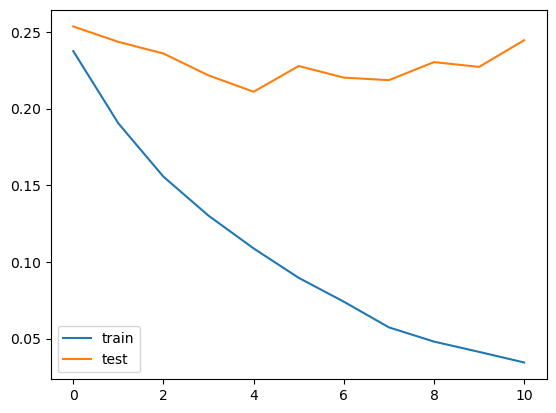

In [97]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend();

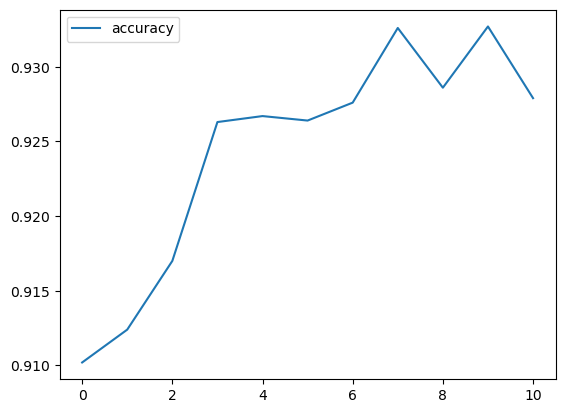

In [131]:
plt.plot(accuracy, label='accuracy')
plt.legend();

In [99]:
model[:2]

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [112]:
X, label = next(iter(DataLoader(mnist_test, batch_size=1)))
X_pred = model[:2](X)[0]

In [114]:
mnist_test.classes[label]

'Ankle boot'

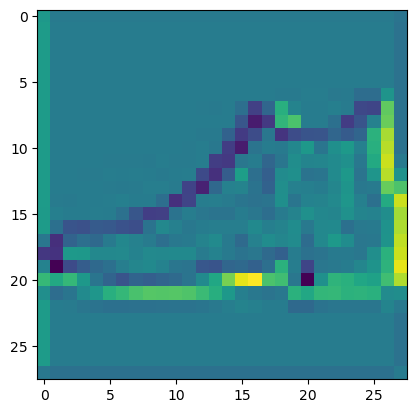

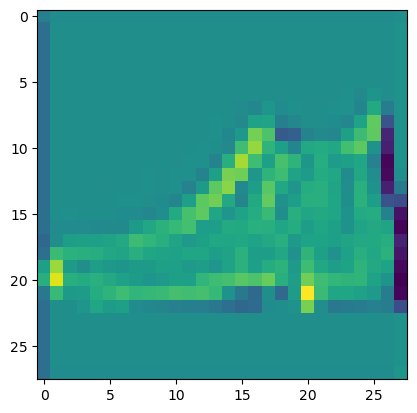

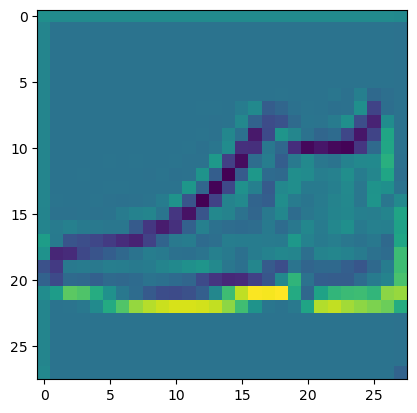

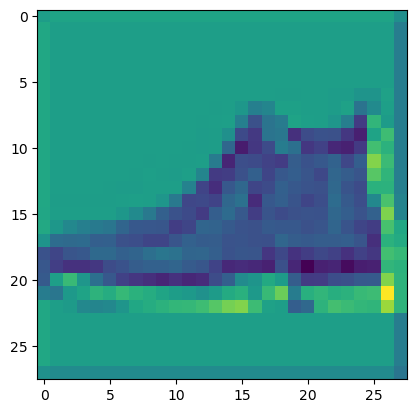

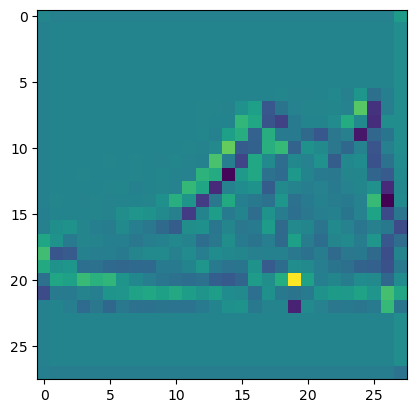

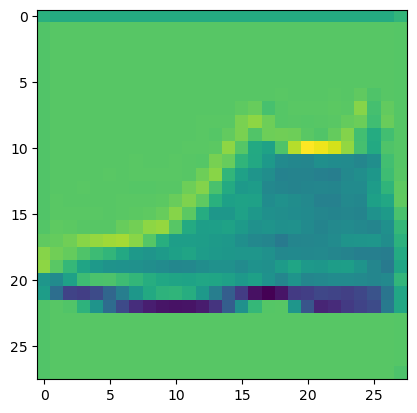

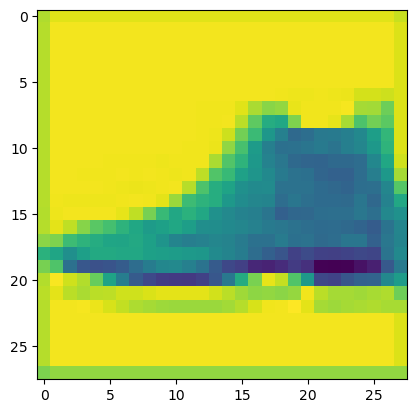

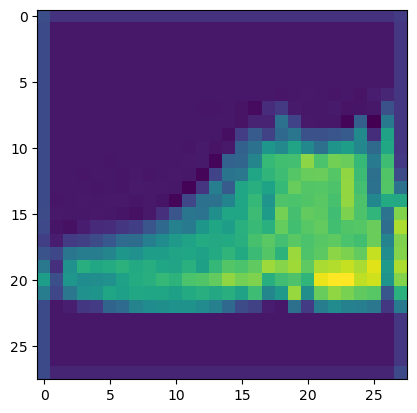

In [111]:
for i in X_pred:
    plt.imshow(i.detach().numpy())
    plt.show()

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [121]:
cifar_train = datasets.CIFAR10('./cifar_mnist/train', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

cifar_test = datasets.CIFAR10('./cifar_mnist/train', train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting ./cifar_mnist/train\cifar-10-python.tar.gz to ./cifar_mnist/train
Files already downloaded and verified


In [132]:
model = torch.nn.Sequential(
    torch.nn.BatchNorm2d(3),
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 2048),
    torch.nn.ReLU(),
    torch.nn.Linear(2048, 32),
    torch.nn.ReLU(2),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(32, len(cifar_train.classes))
)

In [133]:
params = []
for param in model.parameters():
    params.append(torch.prod(torch.tensor(param.shape)))

sum(params)

tensor(6359408)

In [134]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, cifar_train, cifar_test, 5)

Epoch 1
Train loss 2.0600715097115962
Test loss 1.8458609580993652
--------------------
Epoch 2
Train loss 1.8453547467990798
Test loss 1.7344647645950317
--------------------
Epoch 3
Train loss 1.7535068453574667
Test loss 1.6578714847564697
--------------------
Epoch 4
Train loss 1.6794818445127837
Test loss 1.5908665657043457
--------------------
Epoch 5
Train loss 1.6276297557110688
Test loss 1.54839289188385
--------------------
Epoch 6
Train loss 1.5823566755469964
Test loss 1.534385323524475
--------------------
Wall time: 5min 56s


In [135]:
accuracy = [i.item() for i in accuracy]

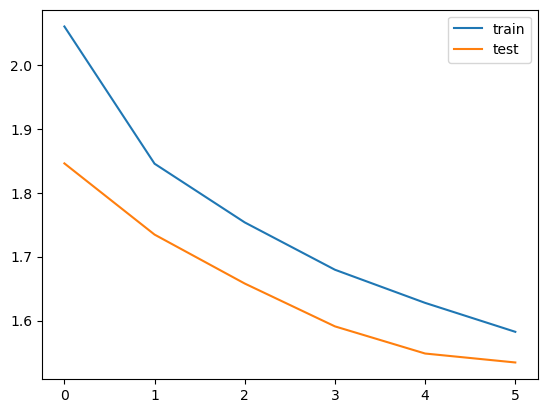

In [136]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend();

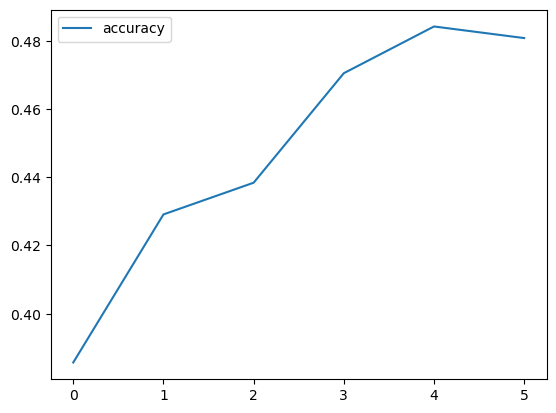

In [137]:
plt.plot(accuracy, label='accuracy')
plt.legend();

In [149]:
y_pred = torch.zeros(cifar_test.data.shape[0])
model.eval()
with torch.no_grad():
    i = 0
    for images, labels in DataLoader(cifar_test, batch_size=64):
        proba = model(images)
    
        y_pred[i:i + 64] += proba.argmax(1)
        i += 64

cf_matrix = confusion_matrix(cifar_test.targets, y_pred.long())

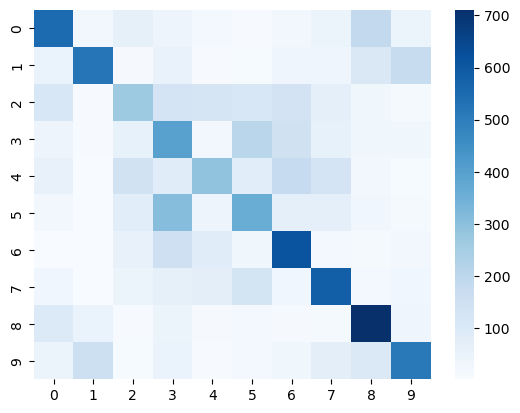

In [150]:
sns.heatmap(cf_matrix, cmap='Blues');

In [151]:
torch.save(model.state_dict(), 'cifar_using_linear_nn')

In [157]:
X = torch.tensor(cifar_test.data[0:1]).float().reshape(1, 3, 32, 32)

In [159]:
id_pred = model(X).argmax(dim=1).item()

True label - airplane
Predict label - airplane


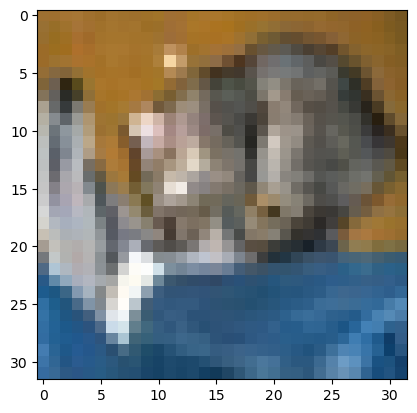

In [160]:
print(f'True label - {cifar_test.classes[0]}\n'
      f'Predict label - {cifar_test.classes[id_pred]}')
plt.imshow((cifar_test.data[0]));

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [161]:
model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 16, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 64, (3, 3), padding=1),
    torch.nn.ReLU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 128, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(16 * 128, len(cifar_train.classes))
)

In [162]:
params = []
for param in model.parameters():
    params.append(torch.prod(torch.tensor(param.shape)))

sum(params)

tensor(141296)

In [163]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, cifar_train, cifar_test, 5)

Epoch 1
Train loss 1.4426057436028306
Test loss 1.1358898878097534
--------------------
Epoch 2
Train loss 1.032860137370168
Test loss 0.9545393586158752
--------------------
Epoch 3
Train loss 0.8807981969142447
Test loss 0.8709600567817688
--------------------
Epoch 4
Train loss 0.7913183630729208
Test loss 0.8173661828041077
--------------------
Epoch 5
Train loss 0.721817745846145
Test loss 0.7638043761253357
--------------------
Epoch 6
Train loss 0.6664976015382883
Test loss 0.7762187719345093
--------------------
Wall time: 12min 6s


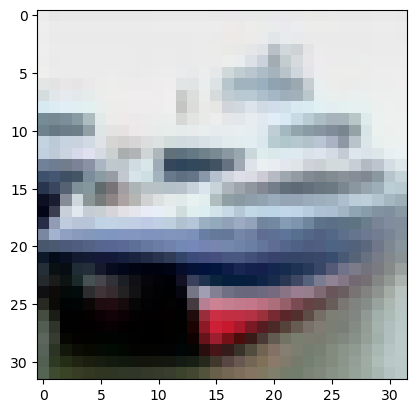

In [166]:
plt.imshow(cifar_test.data[1:2].reshape(32, 32, 3));

In [168]:
accuracy = [i.item() for i in accuracy]

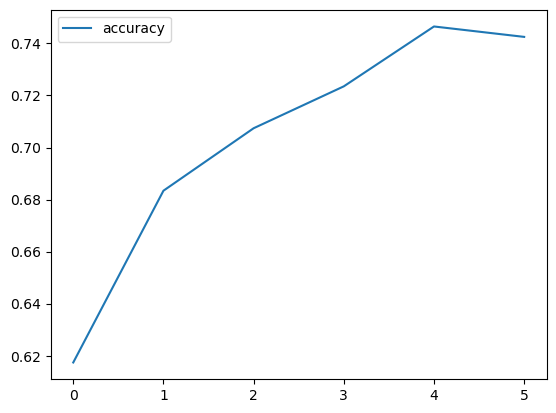

In [169]:
plt.plot(accuracy, label='accuracy')
plt.legend();

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [171]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|█████████████████████████████████████████████████████████████████████████████| 1371/1371 [00:11<00:00, 124.40it/s]


In [173]:
from torchvision.datasets import ImageFolder

monkey_train = ImageFolder(
    'training/training',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((400, 400))
        ]
    )
)

monkey_test = ImageFolder(
    'validation/validation',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((400, 400))
        ]
    )
)

In [174]:
monkey_train

Dataset ImageFolder
    Number of datapoints: 1097
    Root location: training/training
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=(400, 400), interpolation=bilinear, max_size=None, antialias=None)
           )

In [183]:
X = next(iter(DataLoader(monkey_train, batch_size=1)))[0][0].permute(1, 2, 0)

In [184]:
X

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

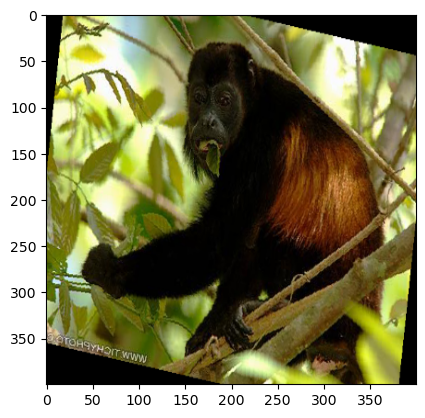

In [185]:
plt.imshow(X);

In [188]:
model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 16, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(128),
    torch.nn.Conv2d(128, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Flatten(),
    torch.nn.Linear(3200, 128),
    torch.nn.CELU(),
    torch.nn.Linear(128, 10)
)

In [189]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, monkey_train, monkey_test, 5)

Epoch 1
Train loss 2.1255528926849365
Test loss inf
--------------------
Epoch 2
Train loss 1.7172925472259521
Test loss inf
--------------------
Epoch 3
Train loss 1.3698100646336873
Test loss inf
--------------------
Epoch 4
Train loss 1.298863689104716
Test loss inf
--------------------
Epoch 5
Train loss 1.1239351431528728
Test loss inf
--------------------
Epoch 6
Train loss 1.0862483183542888
Test loss inf
--------------------
Wall time: 37min 9s


In [190]:
accuracy = [i.item() for i in accuracy]

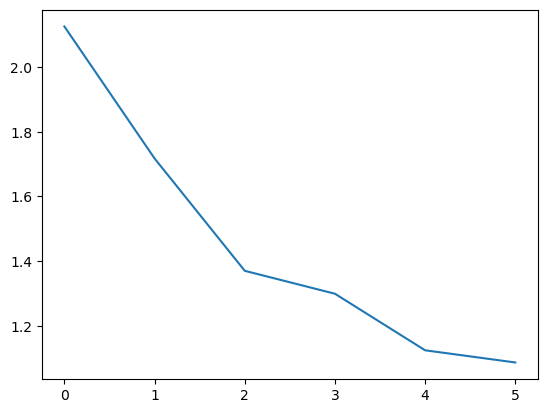

In [192]:
plt.plot(train_loss);

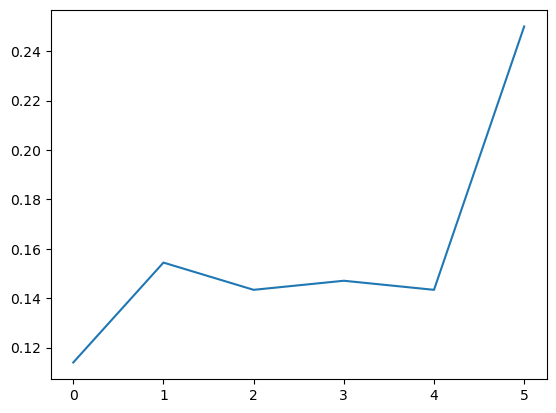

In [194]:
plt.plot(accuracy);

In [199]:
# Видно, что нужно увеличить параметры скрытых слоев, так как долго обучается
# И нужно больше эпох, так как ошибка еще падает

In [197]:
y_pred = torch.zeros(len(monkey_test.targets))
model.eval()
with torch.no_grad():
    i = 0
    for images, labels in DataLoader(monkey_test, batch_size=64):
        proba = model(images)
    
        y_pred[i:i + 64] += proba.argmax(1)
        i += 64

cf_matrix = confusion_matrix(monkey_test.targets, y_pred.long())

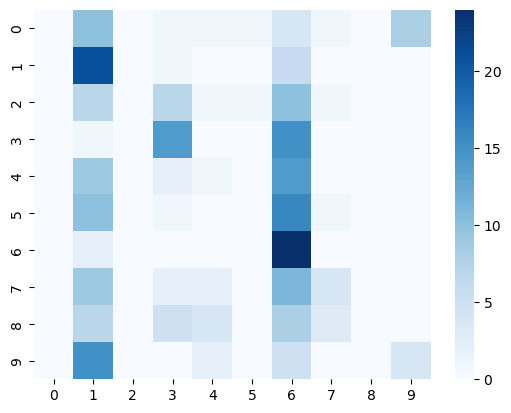

In [198]:
sns.heatmap(cf_matrix, cmap='Blues');

In [205]:
X, name = next(iter(DataLoader(monkey_test)))

In [207]:
id_pred = model(X).argmax(dim=1).item()

In [209]:
X = X.reshape(3, 400, 400).permute(1, 2, 0)

In [214]:
print(f'True - {name.item()}\n'
     f'Pred - {id_pred}')

True - 0
Pred - 9


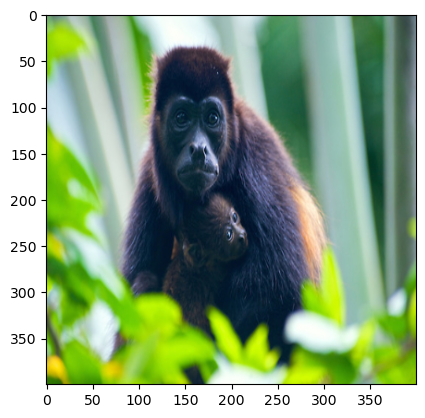

In [215]:
plt.imshow(X);

In [216]:
# Нулевой класс плохо научилась опознавать, видно на cf_matrix

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [217]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|███████████████████████████████████████████████████████████████████████████| 25004/25004 [00:41<00:00, 601.22it/s]


In [218]:
catdog_train = ImageFolder(
    'cats_dogs/train/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((512, 512))
        ]
    )
)

catdog_test = ImageFolder(
    'cats_dogs/test/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((512, 512))
        ]
    )
)

In [220]:
model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 8, (4, 4), stride=3),
    torch.nn.MaxPool2d((4, 4)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(8),
    torch.nn.Conv2d(8, 128, (4, 4), stride=3),
    torch.nn.MaxPool2d((5, 5)),
    torch.nn.CELU(),

    torch.nn.Flatten(),
    torch.nn.Linear(512, 128),
    torch.nn.CELU(),
    torch.nn.Linear(128, 2)
)

In [221]:
%%time
model, train_loss, test_loss, accuracy = train_model(model, catdog_train, catdog_test, 5)

Epoch 1
Train loss 0.6690277703430342
Test loss 0.846590518951416
--------------------
Epoch 2
Train loss 0.5939806660880214
Test loss 0.8214879035949707
--------------------
Epoch 3
Train loss 0.5397063519643701
Test loss 0.8340469002723694
--------------------
Epoch 4
Train loss 0.5057057414365851
Test loss 0.6836750507354736
--------------------
Epoch 5
Train loss 0.5013793033102284
Test loss 0.6530010104179382
--------------------
Epoch 6
Train loss 0.47094266505345056
Test loss 0.6625882983207703
--------------------
Wall time: 2h 14min 2s


In [222]:
accuracy = [i.item() for i in accuracy]

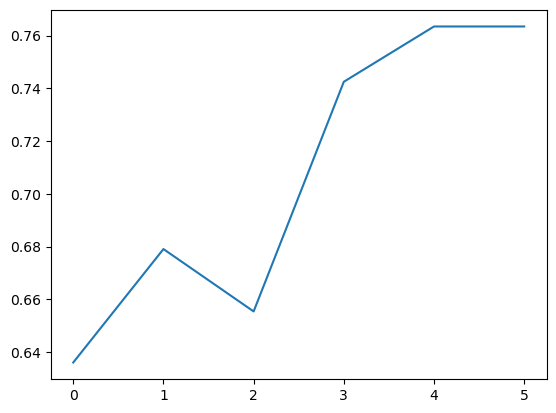

In [224]:
plt.plot(accuracy);

In [225]:
# С увеличением эпох метрика растет 

In [228]:
y_pred = torch.zeros(len(catdog_test.targets))
model.eval()
with torch.no_grad():
    i = 0
    for images, labels in DataLoader(catdog_test, batch_size=64):
        proba = model(images)
    
        y_pred[i:i + 64] += proba.argmax(1)
        i += 64

cf_matrix = confusion_matrix(catdog_test.targets, y_pred.long())

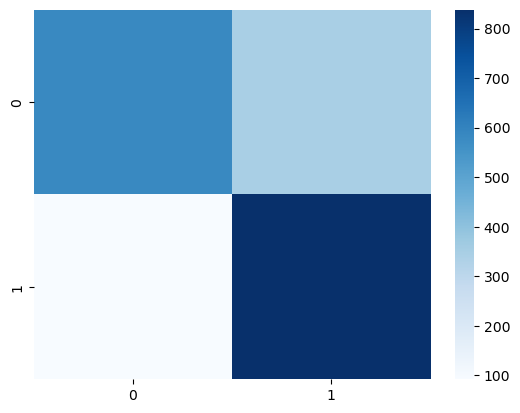

In [229]:
sns.heatmap(cf_matrix, cmap='Blues');

In [230]:
X, name = next(iter(DataLoader(catdog_test)))

In [231]:
id_pred = model(X).argmax(dim=1).item()

In [233]:
X = X.reshape(3, 512, 512).permute(1, 2, 0)

In [234]:
print(f'True - {name.item()}\n'
     f'Pred - {id_pred}')

True - 0
Pred - 0


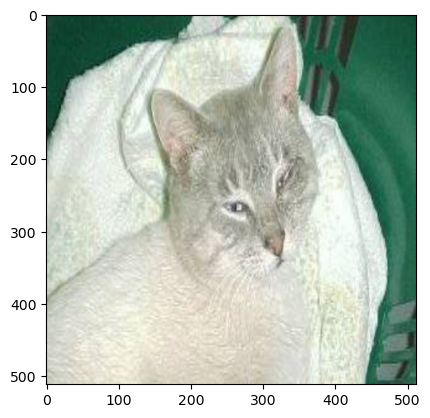

In [236]:
plt.imshow(X);

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


In [6]:
from torchvision.models import vgg16

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
vgg16_model = vgg16(True)

C:\Users\Xiaomi\anaconda3\envs\fa-ml-course\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
C:\Users\Xiaomi\anaconda3\envs\fa-ml-course\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torchvision.datasets import ImageFolder

monkey_train = ImageFolder(
    'training/training',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean, std)
        ]
    )
)

monkey_test = ImageFolder(
    'validation/validation',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean, std)
        ]
    )
)

In [8]:
vgg16_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
vgg16_model.classifier.add_module('add_layer', torch.nn.Linear(1000, 10))

In [10]:
vgg16_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (add_layer): Linear(in_features=1000, out_features=10, bias=True)
)

In [ ]:
%%time
model, train_loss, test_loss, accuracy = train_model(vgg16_model, monkey_train, monkey_test, 2)

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [5]:
from torchvision.models import resnet18

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resnet = resnet18(True)

C:\Users\Xiaomi\anaconda3\envs\fa-ml-course\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
C:\Users\Xiaomi\anaconda3\envs\fa-ml-course\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
from torchvision.datasets import ImageFolder

catdog_train = ImageFolder(
    'cats_dogs/train/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean, std)
        ]
    )
)

catdog_test = ImageFolder(
    'cats_dogs/test/',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean, std)
        ]
    )
)

In [9]:
for i in resnet.parameters():
    i.requires_grad = False

In [11]:
resnet.fc = torch.nn.Linear(512, 2)

In [12]:
# %%time
# model, train_loss, test_loss, accuracy = train_model(resnet, catdog_train, catdog_test, 2)

In [13]:
# Нужно запускать на google colab